In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter as fsf
from matplotlib.gridspec import GridSpec
from plots.mpltoolkit import named_colors, mpl_loc, fancy_legend, load_mpl_presets, append_axes, markers
import vice
from vice.yields.presets import JW20
vice.yields.ccsne.settings["mg"] = 0.00261
vice.yields.sneia.settings["mg"] = 0
import numpy as np
import math as m
import sys
sys.path.append("..")
from src.utils import exponential
load_mpl_presets()
print(sys.version_info)

/Users/astrobeard/Work/Research/VICErepos/VICE/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


sys.version_info(major=3, minor=8, micro=8, releaselevel='final', serial=0)


In [2]:
raw = np.genfromtxt("../data/gsechem.dat")
data = {}
data["[fe/h]"] = raw[:, 0]
data["[fe/h]_err"] = raw[:, 1]
data["[mg/fe]"] = raw[:, 2]
data["[mg/fe]_err"] = raw[:, 3]
data["age"] = [10**_ for _ in raw[:, 4]]
data["age_err"] = [10**_ for _ in raw[:, 5]]

Median [Fe/H] error: 0.0576
Median [Mg/Fe] error: 0.0565


/Users/astrobeard/Work/Research/VICErepos/VICE/vice/core/pickles.py:310: UserWarning: Encoding functions along with VICE outputs requires the package dill (installable via pip). The following attribute will not be saved with this output: func
  warnings.warn("""\
<ipython-input-4-3c22fe5f43b6>:106: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


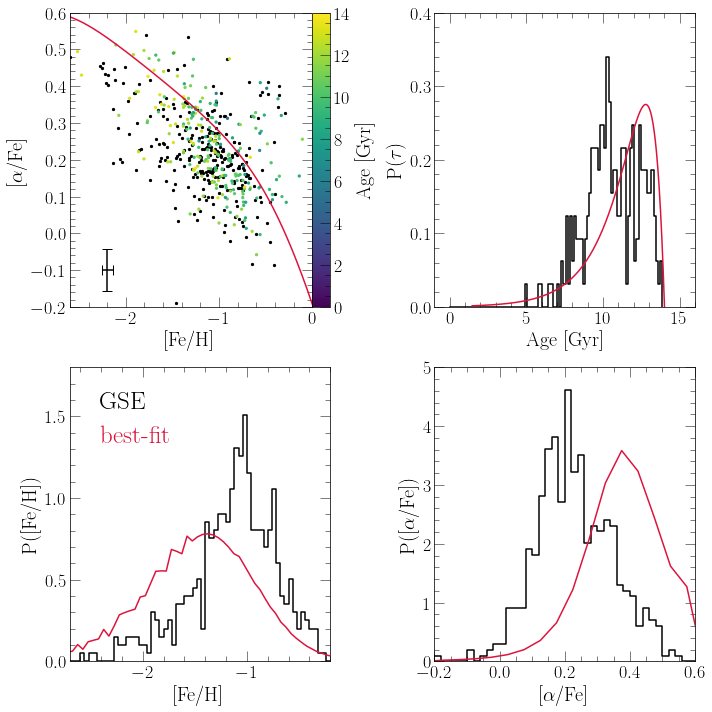

In [4]:
fig = plt.figure(figsize = (10, 10))
axes = 2 * [None]
for i in range(len(axes)):
    axes[i] = 2 * [None]
    for j in range(len(axes[i])):
        axes[i][j] = fig.add_subplot(221 + 2 * i + j)

axes[0][0].set_xlabel("[Fe/H]")
axes[0][0].set_ylabel(r"[$\alpha$/Fe]")
axes[0][0].set_xlim([-2.6, 0])
axes[0][0].set_ylim([-0.2, 0.6])

med_ofe_err = np.median(data["[mg/fe]_err"])
med_feh_err = np.median(data["[fe/h]_err"])
print("Median [Fe/H] error: %.4f" % (med_feh_err))
print("Median [Mg/Fe] error: %.4f" % (med_ofe_err))
kwargs = {
    "c": named_colors()["black"],
    "xerr": med_feh_err,
    "yerr": med_ofe_err,
    "linestyle": "None"
}
axes[0][0].errorbar(-2.2, -0.1, **kwargs)

endtime = 12.54
with vice.singlezone(name = "bestfit") as sz:
    sz.elements = ["fe", "mg"]
    sz.func = exponential(timescale = 0.83)
    sz.mode = "ifr"
    sz.Mg0 = 0
    sz.nthreads = 2
    sz.tau_star = 58.93
    sz.eta = 29.99
    sz.dt = endtime / 1000
    out = sz.run(np.linspace(0, endtime, 1001), overwrite = True, capture = True)
    axes[0][0].plot(out.history["[fe/h]"], out.history["[mg/fe]"],
        c = named_colors()["crimson"])

hasages = list(filter(lambda _: not np.isnan(data["age"][_]), range(len(data["age"]))))
noages = list(filter(lambda _: np.isnan(data["age"][_]), range(len(data["age"]))))
kwargs = {
    "s": 5,
    "c": named_colors()["black"]
}
xvals = [data["[fe/h]"][_] for _ in noages]
yvals = [data["[mg/fe]"][_] for _ in noages]
axes[0][0].scatter(xvals, yvals, **kwargs)

kwargs["c"] = [data["age"][_] for _ in hasages]
kwargs["vmin"] = 0
kwargs["vmax"] = 14
kwargs["cmap"] = "viridis"
xvals = [data["[fe/h]"][_] for _ in hasages]
yvals = [data["[mg/fe]"][_] for _ in hasages]
sc = axes[0][0].scatter(xvals, yvals, **kwargs)

cbar_ax = fig.add_axes([0.92, 0.05, 0.02, 0.95])
cbar = plt.colorbar(sc, cax = cbar_ax, pad = 0.0, orientation = "vertical")
cbar.set_label("Age [Gyr]", labelpad = 5)
cbar.set_ticks(range(0, 16, 2))

axes[0][1].set_xlabel("Age [Gyr]")
axes[0][1].set_ylabel(r"P($\tau$)")
axes[0][1].set_xlim([-1, 16])
# axes[0][1].set_xticks([0, 2, 4, 6, 8, 10])
axes[0][1].set_ylim([0, 0.4])
axes[0][1].set_yticks([0, 0.1, 0.2, 0.3, 0.4])
shift = 14 - endtime
hist, bins = np.histogram(data["age"], bins = 100, range = [0, 14], density = True)
axes[0][1].step(bins[:-1], hist, where = "post", c = named_colors()["black"])
xvals = [_ + shift for _ in out.history["lookback"]]
dt = out.history["time"][1] - out.history["time"][0]
norm = sum(out.history["sfr"]) * dt
agedist = [_ / norm for _ in out.history["sfr"]]
axes[0][1].plot(xvals, agedist, c = named_colors()["crimson"])

axes[1][0].set_xlabel("[Fe/H]")
axes[1][0].set_ylabel("P([Fe/H])")
axes[1][0].set_xlim([-2.7, -0.2])
axes[1][0].set_ylim([0, 1.8])
axes[1][0].set_yticks([0, 0.5, 1.0, 1.5])
hist, bins = np.histogram(data["[fe/h]"], bins = 100, range = [-3, 1], density = True)
axes[1][0].step(bins[:-1], hist, where = "post", c = named_colors()["black"],
    label = "GSE")
xvals = [(a + b) / 2 for a, b in zip(out.mdf["bin_edge_left"], out.mdf["bin_edge_right"])]
axes[1][0].plot(xvals, out.mdf["dn/d[fe/h]"], c = named_colors()["crimson"],
    label = "best-fit")

kwargs = {
    "loc": mpl_loc("upper left"),
    "ncol": 1,
    "handlelength": 0,
    "fontsize": 25
}
leg = axes[1][0].legend(**kwargs)
fancy_legend(leg, ["black", "crimson"])

axes[1][1].set_xlabel(r"[$\alpha$/Fe]")
axes[1][1].set_ylabel(r"P([$\alpha$/Fe])")
axes[1][1].set_xlim([-0.2, 0.6])
axes[1][1].set_ylim([0, 5])
hist, bins = np.histogram(data["[mg/fe]"], bins = 100, range = [-1, 1], density = True)
axes[1][1].step(bins[:-1], hist, where = "post", c = named_colors()["black"])
axes[1][1].plot(xvals, out.mdf["dn/d[mg/fe]"], c = named_colors()["crimson"])

plt.tight_layout()
plt.subplots_adjust(wspace = 0.4)
axes[0][0].set_position([
    axes[0][0].get_position().x0,
    axes[0][0].get_position().y0,
    axes[0][0].get_position().x1 - axes[0][0].get_position().x0 - 0.025,
    axes[0][0].get_position().y1 - axes[0][0].get_position().y0
])
cbar_ax.set_position([
    axes[0][0].get_position().x1,
    axes[0][0].get_position().y0,
    0.025,
    axes[0][0].get_position().y1 - axes[0][0].get_position().y0
])
# for ext in ["pdf", "jpeg"]: plt.savefig("./GSE_distributions.%s" % (ext))
plt.show()